# 03 feature engineering SIMPLE

## Purpose
To be filled during project development

## Steps
1. 
2. 
3. 

In [ ]:
# CELL 1: Setup

import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import MinMaxScaler

# Constants
RAW_DATA_PATH = os.path.join("data", "raw", "eurusd_raw.csv")
PROCESSED_DATA_DIR = os.path.join("data", "processed")
TRAIN_DATA_PATH = os.path.join(PROCESSED_DATA_DIR, "train.csv")
TEST_DATA_PATH = os.path.join(PROCESSED_DATA_DIR, "test.csv")
SCALER_PATH = os.path.join(PROCESSED_DATA_DIR, "scaler.pkl")

print("🔧 SIMPLE Feature Engineering")
print("="*50)


In [ ]:
print("Loading raw data...")
if not os.path.exists(RAW_DATA_PATH):
    print(f"Error: {RAW_DATA_PATH} not found. Run ingest_data.py first.")

# Load data, skipping the 2nd and 3rd lines which contain Ticker info and blank Date line
df = pd.read_csv(RAW_DATA_PATH, index_col=0, parse_dates=True, skiprows=[1, 2])

In [ ]:
# Verify we have numeric data
try:
    df['Close'] = df['Close'].astype(float)
except ValueError:
    # Fallback if the skipping schema didn't match perfectly, try reading all and cleaning
    print("Warning: Simple skip failed, attempting robust cleaning...")
    df = pd.read_csv(RAW_DATA_PATH, index_col=0, parse_dates=True)
    # Drop rows that contain metadata (strings)
    df = df[pd.to_numeric(df['Close'], errors='coerce').notnull()]
    df = df.astype(float)

In [ ]:
# Feature Engineering
print("Feature Engineering...")
# Daily Returns (Percentage)
df['Return'] = df['Close'].pct_change()

# 5-day SMA
df['MA_5'] = df['Close'].rolling(window=5).mean()

# Lagged Returns
for lag in [1, 2, 3, 5]:
    df[f'Lag_{lag}'] = df['Return'].shift(lag)
    
# Drop NaNs created by rolling and shifting and pct_change
df = df.dropna()

### Define features and target

We are predicting Tomorrow's Return, so we need to shift the target or features.

Standard approach: Predict Return_t using information available at t-1.

But description says "Forecast Tomorrow's EUR/USD Daily Return". 

So if we are at row `t` (today), we want to predict `Return_{t+1}`.

Let's create a 'Target' column which is 'Return' shifted by -1.

In [ ]:
df['Target'] = df['Return'].shift(-1)
df = df.dropna() # Drop the last row which has no target
display(df.head())

In [ ]:
# Split Chronologically (80/20)
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


In [ ]:
# Create a copy of Return for ARIMA (unscaled)
train_df['Return_Unscaled'] = train_df['Return']
test_df['Return_Unscaled'] = test_df['Return']

In [ ]:
# Scaling
print("Scaling data...")
feature_cols = ['Return', 'MA_5', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5']
# Note: We scale features. Target usually doesn't need scaling for Regression/ARIMA but might helpful for LSTM. 
# However task says "Forecast Daily Returns", and we convert back to price later. 
# Let's scale features only for now as is typical for inputs. 
# Actually, for LSTM it's often good to scale everything. 
# Let's scale features. Target is a percentage, already small scale, so maybe fine. 
# Requirement: "Fit a MinMaxScaler on Train data only; transform both Train and Test."

scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

In [ ]:
def preprocess_data():
    """
    Loads raw data, performs feature engineering, splits, scales, and saves processed data.
    """
    print("Loading raw data...")
    if not os.path.exists(RAW_DATA_PATH):
        print(f"Error: {RAW_DATA_PATH} not found. Run ingest_data.py first.")
        return

    # Load data, skipping the 2nd and 3rd lines which contain Ticker info and blank Date line
    df = pd.read_csv(RAW_DATA_PATH, index_col=0, parse_dates=True, skiprows=[1, 2])
    
    # Verify we have numeric data
    try:
        df['Close'] = df['Close'].astype(float)
    except ValueError:
        # Fallback if the skipping schema didn't match perfectly, try reading all and cleaning
        print("Warning: Simple skip failed, attempting robust cleaning...")
        df = pd.read_csv(RAW_DATA_PATH, index_col=0, parse_dates=True)
        # Drop rows that contain metadata (strings)
        df = df[pd.to_numeric(df['Close'], errors='coerce').notnull()]
        df = df.astype(float)
    
    # Feature Engineering
    print("Feature Engineering...")
    # Daily Returns (Percentage)
    df['Return'] = df['Close'].pct_change()
    
    # 5-day SMA
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    
    # Lagged Returns
    for lag in [1, 2, 3, 5]:
        df[f'Lag_{lag}'] = df['Return'].shift(lag)
        
    # Drop NaNs created by rolling and shifting and pct_change
    df = df.dropna()
    
    # Define features and target
    # We are predicting Tomorrow's Return, so we need to shift the target or features.
    # Standard approach: Predict Return_t using information available at t-1.
    # But description says "Forecast Tomorrow's EUR/USD Daily Return". 
    # So if we are at row `t` (today), we want to predict `Return_{t+1}`.
    # Let's create a 'Target' column which is 'Return' shifted by -1.
    
    df['Target'] = df['Return'].shift(-1)
    df = df.dropna() # Drop the last row which has no target
    
    # Split Chronologically (80/20)
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size].copy()
    test_df = df.iloc[train_size:].copy()
    
    print(f"Train set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Create a copy of Return for ARIMA (unscaled)
    train_df['Return_Unscaled'] = train_df['Return']
    test_df['Return_Unscaled'] = test_df['Return']
    
    # Scaling
    print("Scaling data...")
    feature_cols = ['Return', 'MA_5', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5']
    # Note: We scale features. Target usually doesn't need scaling for Regression/ARIMA but might helpful for LSTM. 
    # However task says "Forecast Daily Returns", and we convert back to price later. 
    # Let's scale features only for now as is typical for inputs. 
    # Actually, for LSTM it's often good to scale everything. 
    # Let's scale features. Target is a percentage, already small scale, so maybe fine. 
    # Requirement: "Fit a MinMaxScaler on Train data only; transform both Train and Test."
    
    scaler = MinMaxScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df[feature_cols] = scaler.transform(test_df[feature_cols])
    
    # Save
    os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
    train_df.to_csv(TRAIN_DATA_PATH)
    test_df.to_csv(TEST_DATA_PATH)
    joblib.dump(scaler, SCALER_PATH)
    
    print(f"Processed data saved to {PROCESSED_DATA_DIR}")

    # Upload to S3
    s3_bucket = os.getenv("S3_BUCKET")
    if s3_bucket:
        try:
            import boto3
            s3 = boto3.client('s3')
            
            artifacts = [TRAIN_DATA_PATH, TEST_DATA_PATH, SCALER_PATH]
            
            print(f"Uploading artifacts to s3://{s3_bucket}...")
            for artifact in artifacts:
                s3_key = artifact # Keep same path structure: data/processed/...
                s3.upload_file(artifact, s3_bucket, s3_key)
                print(f"  ✅ Uploaded {artifact}")
                
        except Exception as e:
            print(f"  ❌ Upload failed: {e}")
    else:
        print("  ⚠️ S3_BUCKET not set in .env, skipping upload.")


In [1]:
# CELL 1: Setup
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import joblib

# Path setup
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

DATA_RAW = os.path.join(project_root, 'data', 'raw')
DATA_PROCESSED = os.path.join(project_root, 'data', 'processed')
FIGURES = os.path.join(project_root, 'figures')
MODELS = os.path.join(project_root, 'models')

for dir_path in [DATA_PROCESSED, FIGURES, MODELS]:
    os.makedirs(dir_path, exist_ok=True)

print("🔧 SIMPLE Feature Engineering for LSTM")
print("="*50)


🔧 SIMPLE Feature Engineering for LSTM


In [2]:

# CELL 2: Load data
print("\n📂 Loading data...")
raw_data_path = os.path.join(DATA_RAW, 'eurusd_raw.csv')

if not os.path.exists(raw_data_path):
    print(f"❌ File not found: {raw_data_path}")
    print("Run notebook 1 first!")
    raise FileNotFoundError(f"File not found: {raw_data_path}")

df = pd.read_csv(raw_data_path, index_col=0, parse_dates=True)
print(f"✅ Loaded {len(df)} rows")
print(f"📅 {df.index[0].date()} to {df.index[-1].date()}")



📂 Loading data...
✅ Loaded 779 rows
📅 2022-12-12 to 2025-12-09



📊 STEP 1: Prepare data for LSTM (Simple approach)
----------------------------------------
Using column: 'close' for predictions
Price range: $1.0244 to $1.1871


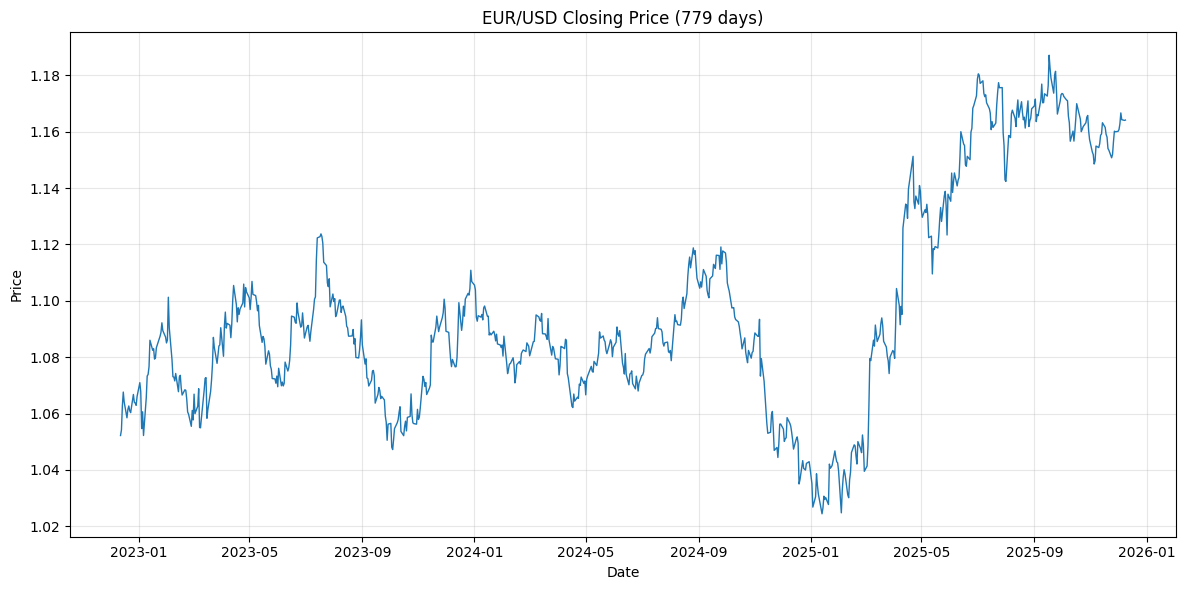

In [3]:

# CELL 3: Prepare data SIMPLY
print("\n📊 STEP 1: Prepare data for LSTM (Simple approach)")
print("-"*40)

# Use only the 'Close' price column
# Check column names (might be 'close' or 'Close')
if 'close' in df.columns:
    price_col = 'close'
elif 'Close' in df.columns:
    price_col = 'Close'
    df = df.rename(columns={'Close': 'close'})
else:
    print(f"❌ No close price column found. Available: {list(df.columns)}")
    raise KeyError("Close price column not found")

# Extract just the closing prices
data = df[[price_col]].copy()
print(f"Using column: '{price_col}' for predictions")
print(f"Price range: ${data[price_col].min():.4f} to ${data[price_col].max():.4f}")

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[price_col], linewidth=1)
plt.title(f'EUR/USD Closing Price ({len(data)} days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES, 'eurusd_price_series.png'), dpi=100)
plt.show()


In [4]:

# CELL 4: Split into train/test FIRST
print("\n🎯 STEP 2: Split data into train/test (70/30 like class example)")
print("-"*40)

# Use 70% for training, 30% for testing
split_ratio = 0.70
split_index = int(len(data) * split_ratio)

train_data = data.iloc[:split_index].copy()
test_data = data.iloc[split_index:].copy()

print(f"Total samples: {len(data)}")
print(f"Training samples: {len(train_data)} ({len(train_data)/len(data)*100:.1f}%)")
print(f"Testing samples:  {len(test_data)} ({len(test_data)/len(data)*100:.1f}%)")
print(f"Train dates: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Test dates:  {test_data.index[0].date()} to {test_data.index[-1].date()}")

# Save the splits
train_data.to_csv(os.path.join(DATA_PROCESSED, 'lstm_simple_train_data.csv'))
test_data.to_csv(os.path.join(DATA_PROCESSED, 'lstm_simple_test_data.csv'))
print("✅ Train/test splits saved")

# CELL 5: Scale the data (separately for train and test)
print("\n📏 STEP 3: Scale data (0 to 1)")
print("-"*40)

scaler = MinMaxScaler(feature_range=(0, 1))

# Scale training data
scaled_train = scaler.fit_transform(train_data)
print(f"Scaled training data shape: {scaled_train.shape}")

# Scale test data (using training scaler)
scaled_test = scaler.transform(test_data)
print(f"Scaled test data shape: {scaled_test.shape}")

# Save the scaler
scaler_path = os.path.join(MODELS, 'lstm_scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")



🎯 STEP 2: Split data into train/test (70/30 like class example)
----------------------------------------
Total samples: 779
Training samples: 545 (70.0%)
Testing samples:  234 (30.0%)
Train dates: 2022-12-12 to 2025-01-13
Test dates:  2025-01-14 to 2025-12-09
✅ Train/test splits saved

📏 STEP 3: Scale data (0 to 1)
----------------------------------------
Scaled training data shape: (545, 1)
Scaled test data shape: (234, 1)
✅ Scaler saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/lstm_scaler.joblib


In [ ]:

# CELL 6: Create sequences for LSTM
print("\n🔄 STEP 4: Create sequences for LSTM")
print("-"*40)

def create_sequences(data, seq_length):
    """Create X (sequences) and y (next value) for LSTM"""
    X, y = [], []
    
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # Previous 'seq_length' values
        y.append(data[i, 0])  # Next value
        
    return np.array(X), np.array(y)

# Use 100 days of history (like your class example)
SEQ_LENGTH = 100
print(f"Creating sequences with {SEQ_LENGTH} days of history")

# Create sequences for training data
X_train, y_train = create_sequences(scaled_train, SEQ_LENGTH)
print(f"Training sequences: {X_train.shape}")
print(f"Training targets:   {y_train.shape}")

# Create sequences for test data
X_test, y_test = create_sequences(scaled_test, SEQ_LENGTH)
print(f"Testing sequences:  {X_test.shape}")
print(f"Testing targets:    {y_test.shape}")

# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\n✅ Final shapes for LSTM:")
print(f"X_train: {X_train.shape} (samples, timesteps, features)")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")



🔄 STEP 4: Create sequences for LSTM
----------------------------------------
Creating sequences with 100 days of history
Training sequences: (445, 100)
Training targets:   (445,)
Testing sequences:  (134, 100)
Testing targets:    (134,)

✅ Final shapes for LSTM:
X_train: (445, 100, 1) (samples, timesteps, features)
y_train: (445,)
X_test:  (134, 100, 1)
y_test:  (134,)


In [6]:

# CELL 7: Save sequences for LSTM training
print("\n💾 STEP 5: Save LSTM sequences")
print("-"*40)

# Save as numpy arrays
np.save(os.path.join(DATA_PROCESSED, 'X_train.npy'), X_train)
np.save(os.path.join(DATA_PROCESSED, 'y_train.npy'), y_train)
np.save(os.path.join(DATA_PROCESSED, 'X_test.npy'), X_test)
np.save(os.path.join(DATA_PROCESSED, 'y_test.npy'), y_test)

print("✅ LSTM sequences saved as .npy files:")
print(f"  {DATA_PROCESSED}/X_train.npy")
print(f"  {DATA_PROCESSED}/y_train.npy")
print(f"  {DATA_PROCESSED}/X_test.npy")
print(f"  {DATA_PROCESSED}/y_test.npy")



💾 STEP 5: Save LSTM sequences
----------------------------------------
✅ LSTM sequences saved as .npy files:
  /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/X_train.npy
  /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/y_train.npy
  /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/X_test.npy
  /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/y_test.npy



📊 STEP 6: Visualize the sequences
----------------------------------------


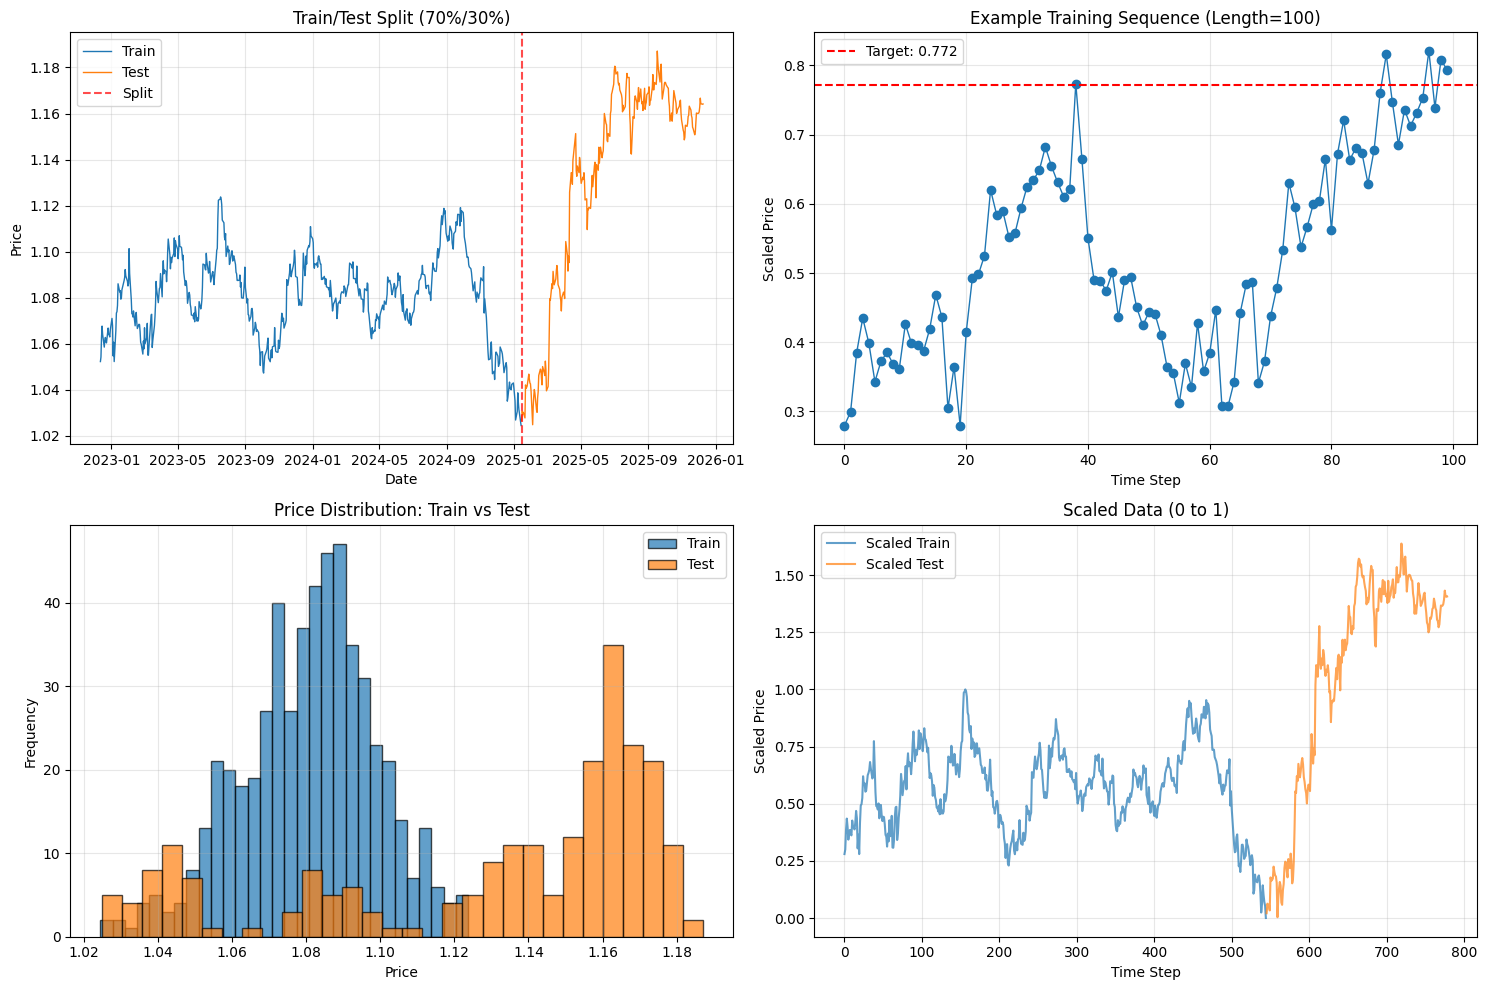

✅ Visualization saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/lstm_sequences_preparation_simple.png


In [7]:

# CELL 8: Visualize what we created
print("\n📊 STEP 6: Visualize the sequences")
print("-"*40)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Train/test split
axes[0, 0].plot(train_data.index, train_data[price_col], label='Train', linewidth=1)
axes[0, 0].plot(test_data.index, test_data[price_col], label='Test', linewidth=1)
axes[0, 0].axvline(x=test_data.index[0], color='red', linestyle='--', alpha=0.7, label='Split')
axes[0, 0].set_title('Train/Test Split (70%/30%)')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Example training sequence
axes[0, 1].plot(range(SEQ_LENGTH), X_train[0].flatten(), marker='o', linewidth=1)
axes[0, 1].axhline(y=y_train[0], color='red', linestyle='--', 
                   label=f'Target: {y_train[0]:.3f}')
axes[0, 1].set_title(f'Example Training Sequence (Length={SEQ_LENGTH})')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Scaled Price')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Data distribution
axes[1, 0].hist(train_data[price_col], bins=30, alpha=0.7, label='Train', edgecolor='black')
axes[1, 0].hist(test_data[price_col], bins=30, alpha=0.7, label='Test', edgecolor='black')
axes[1, 0].set_title('Price Distribution: Train vs Test')
axes[1, 0].set_xlabel('Price')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Scaled data
axes[1, 1].plot(scaled_train, alpha=0.7, label='Scaled Train')
axes[1, 1].plot(range(len(scaled_train), len(scaled_train) + len(scaled_test)), 
                scaled_test, alpha=0.7, label='Scaled Test')
axes[1, 1].set_title('Scaled Data (0 to 1)')
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Scaled Price')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
seq_viz_path = os.path.join(FIGURES, 'lstm_sequences_preparation_simple.png')
plt.savefig(seq_viz_path, dpi=100, bbox_inches='tight')
plt.show()
print(f"✅ Visualization saved to: {seq_viz_path}")


In [8]:

# CELL 9: Summary
print("\n" + "="*60)
print("✅ SIMPLE LSTM PREPARATION COMPLETE")
print("="*60)

print(f"\n1. DATA SPLIT (70/30):")
print(f"   • Train: {len(train_data)} samples")
print(f"   • Test:  {len(test_data)} samples")

print(f"\n2. LSTM SEQUENCES:")
print(f"   • Sequence length: {SEQ_LENGTH} days")
print(f"   • X_train shape: {X_train.shape}")
print(f"   • X_test shape:  {X_test.shape}")

print(f"\n3. FILES SAVED:")
print(f"   • train_data.csv, test_data.csv")
print(f"   • X_train.npy, y_train.npy, X_test.npy, y_test.npy")
print(f"   • lstm_scaler.joblib")
print(f"   • {seq_viz_path}")

print(f"\n4. NEXT STEP:")
print("   • Open 04_lstm_model_simple.ipynb")
print("   • Train LSTM with these prepared sequences")

print("\n🎉 Ready for simple LSTM training!")


✅ SIMPLE LSTM PREPARATION COMPLETE

1. DATA SPLIT (70/30):
   • Train: 545 samples
   • Test:  234 samples

2. LSTM SEQUENCES:
   • Sequence length: 100 days
   • X_train shape: (445, 100, 1)
   • X_test shape:  (134, 100, 1)

3. FILES SAVED:
   • train_data.csv, test_data.csv
   • X_train.npy, y_train.npy, X_test.npy, y_test.npy
   • lstm_scaler.joblib
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/lstm_sequences_preparation_simple.png

4. NEXT STEP:
   • Open 04_lstm_model_simple.ipynb
   • Train LSTM with these prepared sequences

🎉 Ready for simple LSTM training!
